# **Build a transfer learnt model from a model trained on VGG by adding additional layers**

- Cristeena Joseph - 500223331

**Data Preprocessing**       
Scaling and Resizing	- Done  
Image Augmentation	- Done  
Train and test data handled correctly	- Done     
Gaussian Blur, Histogram Equalization and Intensity thresholds	- Not Done

**Model Trained**


Training Time	- Done    
AUC and Confusion Matrix Computed	- Done  
Overfitting/Underfitting checked and handled	- Done

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import time
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_auc_score, classification_report,roc_curve,auc
from sklearn.metrics import accuracy_score

from sklearn.metrics import roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#Read image data
def read_image(data_dir,filepath):
    return cv2.imread(os.path.join(data_dir, filepath))

def resize_image(image, image_size):
    return cv2.resize(image.copy(), image_size,
                      interpolation=cv2.INTER_AREA)

In [5]:
image_array_data = []
image_label = []

In [6]:
# Define the path to your directory
directory_path = '/content/drive/My Drive/emotions/dataset/'
def img_list_return(directory_path,cls_name):
  global image_array_data
  global image_label

  IMAGE_SIZE = 64

  # List all files in the directory
  file_folder = os.path.join(directory_path,cls_name)
  files = os.listdir(file_folder)


  # Print the list of files
  for file in files:
      img_data = read_image(file_folder,file)
      img_data = resize_image(img_data, (IMAGE_SIZE, IMAGE_SIZE))
      img_data = img_data/255
      image_array_data.append(img_data)
      image_label.append(cls_name.lower())

  return image_array_data,image_label

In [7]:
cls_name = "Angry"
image_array_data,image_label = img_list_return(directory_path,cls_name)

In [8]:
cls_name = "Ahegao"
image_array_data,image_label = img_list_return(directory_path,cls_name)

In [9]:
cls_name = "Happy"
image_array_data,image_label = img_list_return(directory_path,cls_name)

In [10]:
cls_name = "Neutral"
image_array_data,image_label = img_list_return(directory_path,cls_name)

In [11]:
cls_name = "Sad"
image_array_data,image_label = img_list_return(directory_path,cls_name)

In [12]:
cls_name = "Surprise"
image_array_data,image_label = img_list_return(directory_path,cls_name)

In [13]:
image_array_data[0]

array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       ...,

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]])

In [44]:
X = np.array(image_array_data)

In [45]:
mapping = {"ahegao": 2, "angry": 0,"happy":1,"sad":3,"neutral":4,"surprise":5}
# Map list values to numerical values
labels = [mapping[value] for value in image_label]

In [46]:
y = np.array(labels)

In [47]:
X.shape

(15453, 64, 64, 3)

In [48]:
y.shape

(15453,)

**Samples of equal proportion**

In [19]:
def create_equal_proportion_subset(X, y):
    unique_classes = np.unique(y)
    min_class_count = min([np.sum(y == cls) for cls in unique_classes])

    X_subset = []
    y_subset = []

    for cls in unique_classes:
        class_indices = np.where(y == cls)[0]
        sampled_indices = np.random.choice(class_indices, min_class_count, replace=False)
        X_subset.append(X[sampled_indices])
        y_subset.append(y[sampled_indices])

    X_subset = np.concatenate(X_subset)
    y_subset = np.concatenate(y_subset)

    return X_subset, y_subset

In [20]:
X,y = create_equal_proportion_subset(X, y)

In [49]:
print('Shape of X:', X.shape)
print('Shape of y:', y.shape)

Shape of X: (15453, 64, 64, 3)
Shape of y: (15453,)


**Data Augmentation**

In [50]:
# Function to create balanced dataset with augmentation for classes with fewer samples
def augment_class(X, y, target_class, target_count):
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    class_indices = np.where(y == target_class)[0]
    class_samples = X[class_indices]

    augmented_images = []
    while len(augmented_images) < target_count:
        for batch in datagen.flow(class_samples, batch_size=1):
            augmented_images.append(batch[0])
            if len(augmented_images) >= target_count:
                break

    X_augmented = np.concatenate([X, np.array(augmented_images)])
    y_augmented = np.concatenate([y, np.full(len(augmented_images), target_class)])

    return X_augmented, y_augmented

In [51]:

X,y = augment_class(X, y, 0, 60)
X,y = augment_class(X, y, 1, 60)
X,y = augment_class(X, y, 2, 60)
X,y = augment_class(X, y, 3, 60)
X,y = augment_class(X, y, 4, 60)
X,y  = augment_class(X, y, 5, 60)


In [52]:
y = to_categorical(y, num_classes=6)

In [53]:
# Display the shape of the data
print('Shape of X:', X.shape)
print('Shape of y:', y.shape)

Shape of X: (15813, 64, 64, 3)
Shape of y: (15813, 6)


In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [27]:

# Load the pre-trained VGG16 model without the top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add new layers on top of the base model
model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(6, activation='softmax')  # 6 output classes for 6 emotions
])

58889256/58889256 [==============================] - 0s 0us/step


In [28]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',  # Use categorical crossentropy for multi-class classification
              metrics=['accuracy'])


In [29]:
# Summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 6)                 1542      
                                                                 
Total params: 15240774 (58.14 MB)
Trainable params: 526086 (2.01 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [30]:
# Record the start time
start_time = time.time()

# Train the model
model.fit(X_train, y_train, epochs=3, batch_size=32)

end_time = time.time()
print(f"Training time taken : {end_time-start_time}")

Epoch 1/3
256/256 [==============================] - 22s 84ms/step - loss: 1.4231 - accuracy: 0.4252
Epoch 2/3
256/256 [==============================] - 21s 82ms/step - loss: 1.2573 - accuracy: 0.4991
Epoch 3/3
256/256 [==============================] - 21s 82ms/step - loss: 1.1833 - accuracy: 0.5257
Training time taken : 65.26264905929565


In [31]:
y_pred_prob = model.predict(X_test)

64/64 [==============================] - 5s 82ms/step


In [32]:
# Convert predictions and true labels from one-hot encoding to label indices
y_val_pred_classes = np.argmax(y_pred_prob, axis=1)
y_val_true_classes = np.argmax(y_test, axis=1)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_val_true_classes, y_val_pred_classes)

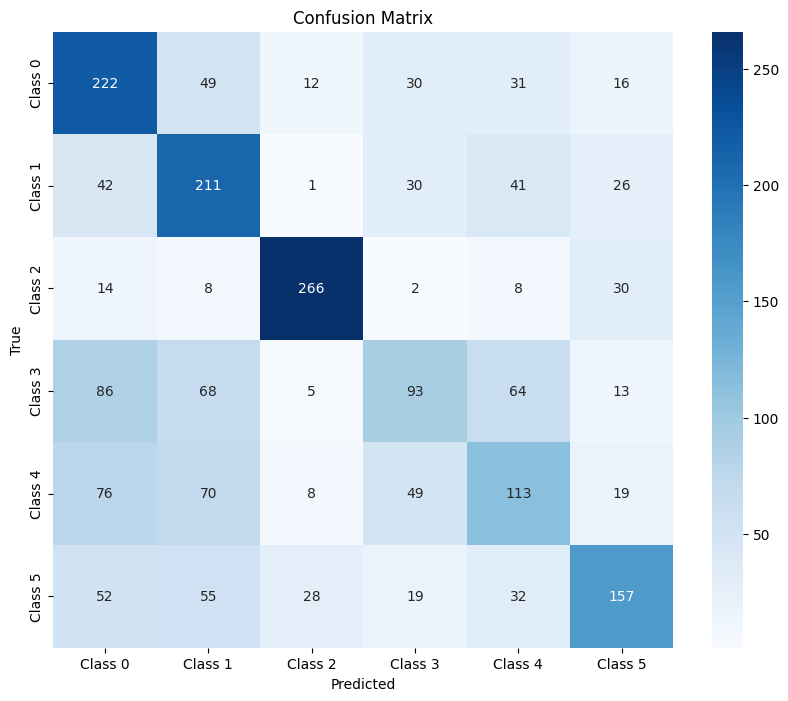

In [33]:
# Compute the confusion matrix
conf_matrix = confusion_matrix(y_val_true_classes, y_val_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[f'Class {i}' for i in range(6)], yticklabels=[f'Class {i}' for i in range(6)])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()



# **Empirical tuning**

In [34]:
# Define function to create the model
def create_model(learning_rate=0.001, dropout_rate=0.5):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

    for layer in base_model.layers:
        layer.trainable = False

    model = models.Sequential([
        base_model,
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(dropout_rate),
        layers.Dense(6, activation='softmax')
    ])

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [37]:
# Define hyperparameter ranges
learning_rates = [0.001, 0.0001]
dropout_rates = [0,0.1]

best_accuracy = 0
best_hyperparams = {}

# Empirical tuning
for lr in learning_rates:
    for dr in dropout_rates:
        model = create_model(learning_rate=lr, dropout_rate=dr)
        model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), verbose=0)

        # Evaluate the model
        y_val_pred = model.predict(X_test)
        y_val_pred_classes = np.argmax(y_val_pred, axis=1)
        y_val_true_classes = np.argmax(y_test, axis=1)
        accuracy = accuracy_score(y_val_true_classes, y_val_pred_classes)

        # Check if this is the best model
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_hyperparams = {'learning_rate': lr, 'dropout_rate': dr}

64/64 [==============================] - 5s 83ms/step


In [38]:
print(f"Best accuracy: {best_accuracy}")
print(f"Best hyperparameters: {best_hyperparams}")

# Train final model with best hyperparameters
final_model = create_model(learning_rate=best_hyperparams['learning_rate'], dropout_rate=best_hyperparams['dropout_rate'])
history = final_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Best accuracy: 0.5498533724340176
Best hyperparameters: {'learning_rate': 0.001, 'dropout_rate': 0.1}
Epoch 1/10
256/256 [==============================] - 29s 107ms/step - loss: 1.3326 - accuracy: 0.4708 - val_loss: 1.2556 - val_accuracy: 0.4946
Epoch 2/10
256/256 [==============================] - 27s 106ms/step - loss: 1.1362 - accuracy: 0.5544 - val_loss: 1.2371 - val_accuracy: 0.5269
Epoch 3/10
256/256 [==============================] - 27s 104ms/step - loss: 1.0313 - accuracy: 0.6004 - val_loss: 1.2348 - val_accuracy: 0.5249
Epoch 4/10
256/256 [==============================] - 26s 104ms/step - loss: 0.9460 - accuracy: 0.6370 - val_loss: 1.2200 - val_accuracy: 0.5254
Epoch 5/10
256/256 [==============================] - 27s 105ms/step - loss: 0.8808 - accuracy: 0.6673 - val_loss: 1.1880 - val_accuracy: 0.5450
Epoch 6/10
256/256 [==============================] - 27s 104ms/step - loss: 0.8059 - accuracy: 0.6917 - val_loss: 1.2884 - val_accuracy: 0.5264
Epoch 7/10
256/256 [========

**Training and test accuracy of best model**

In [39]:
# Get training accuracy from the history object
train_accuracy = history.history['accuracy'][-1]
print(f"Training Accuracy: {train_accuracy * 100:.2f}%")

# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Training Accuracy: 80.08%
64/64 [==============================] - 5s 83ms/step - loss: 1.1674 - accuracy: 0.5445
Test Accuracy: 54.45%


# **Model Finetuning**

Increased the sample data

In [55]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = final_model.fit(X_train, y_train, epochs=10, batch_size=36, validation_data=(X_test, y_test))


Epoch 1/10
352/352 [==============================] - 40s 112ms/step - loss: 1.1662 - accuracy: 0.5777 - val_loss: 1.0074 - val_accuracy: 0.5972
Epoch 2/10
352/352 [==============================] - 38s 109ms/step - loss: 0.9252 - accuracy: 0.6360 - val_loss: 1.0026 - val_accuracy: 0.6159
Epoch 3/10
352/352 [==============================] - 38s 109ms/step - loss: 0.8248 - accuracy: 0.6719 - val_loss: 0.9561 - val_accuracy: 0.6320
Epoch 4/10
352/352 [==============================] - 38s 108ms/step - loss: 0.7276 - accuracy: 0.7108 - val_loss: 0.9750 - val_accuracy: 0.6345
Epoch 5/10
352/352 [==============================] - 39s 111ms/step - loss: 0.6647 - accuracy: 0.7330 - val_loss: 0.9928 - val_accuracy: 0.6285
Epoch 6/10
352/352 [==============================] - 39s 112ms/step - loss: 0.6066 - accuracy: 0.7602 - val_loss: 1.0058 - val_accuracy: 0.6380
Epoch 7/10
352/352 [==============================] - 39s 112ms/step - loss: 0.5517 - accuracy: 0.7840 - val_loss: 1.0357 - val_ac

In [57]:
# Get training accuracy from the history object
train_accuracy = history.history['accuracy'][-1]
print(f"Training Accuracy: {train_accuracy * 100:.2f}%")

# Evaluate the model on the test dataset
test_loss, test_accuracy = final_model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Training Accuracy: 84.01%
99/99 [==============================] - 8s 80ms/step - loss: 1.1119 - accuracy: 0.6273
Test Accuracy: 62.73%


**Learning Rate Scheduler**

In [59]:
from tensorflow.keras.callbacks import LearningRateScheduler

def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

lr_scheduler = LearningRateScheduler(scheduler)
history = final_model.fit(X_train, y_train, epochs=10, batch_size=36, callbacks=[lr_scheduler])


Epoch 1/10
352/352 [==============================] - 32s 90ms/step - loss: 0.3754 - accuracy: 0.8553 - lr: 0.0010
Epoch 2/10
352/352 [==============================] - 32s 90ms/step - loss: 0.3466 - accuracy: 0.8708 - lr: 0.0010
Epoch 3/10
352/352 [==============================] - 31s 89ms/step - loss: 0.3035 - accuracy: 0.8870 - lr: 0.0010
Epoch 4/10
352/352 [==============================] - 31s 88ms/step - loss: 0.2873 - accuracy: 0.8961 - lr: 0.0010
Epoch 5/10
352/352 [==============================] - 31s 88ms/step - loss: 0.2625 - accuracy: 0.9041 - lr: 0.0010
Epoch 6/10
352/352 [==============================] - 31s 88ms/step - loss: 0.2263 - accuracy: 0.9207 - lr: 9.0484e-04
Epoch 7/10
352/352 [==============================] - 31s 88ms/step - loss: 0.1940 - accuracy: 0.9321 - lr: 8.1873e-04
Epoch 8/10
352/352 [==============================] - 31s 87ms/step - loss: 0.1681 - accuracy: 0.9434 - lr: 7.4082e-04
Epoch 9/10
352/352 [==============================] - 31s 88ms/step 

In [60]:
# Get training accuracy from the history object
train_accuracy = history.history['accuracy'][-1]
print(f"Training Accuracy: {train_accuracy * 100:.2f}%")

# Evaluate the model on the test dataset
test_loss, test_accuracy = final_model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Training Accuracy: 96.00%
99/99 [==============================] - 8s 79ms/step - loss: 1.4493 - accuracy: 0.6336
Test Accuracy: 63.36%


In [62]:
y_pred_prob = final_model.predict(X_test)

99/99 [==============================] - 8s 81ms/step


In [63]:
# Convert predictions and true labels from one-hot encoding to label indices
y_val_pred_classes = np.argmax(y_pred_prob, axis=1)
y_val_true_classes = np.argmax(y_test, axis=1)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_val_true_classes, y_val_pred_classes)

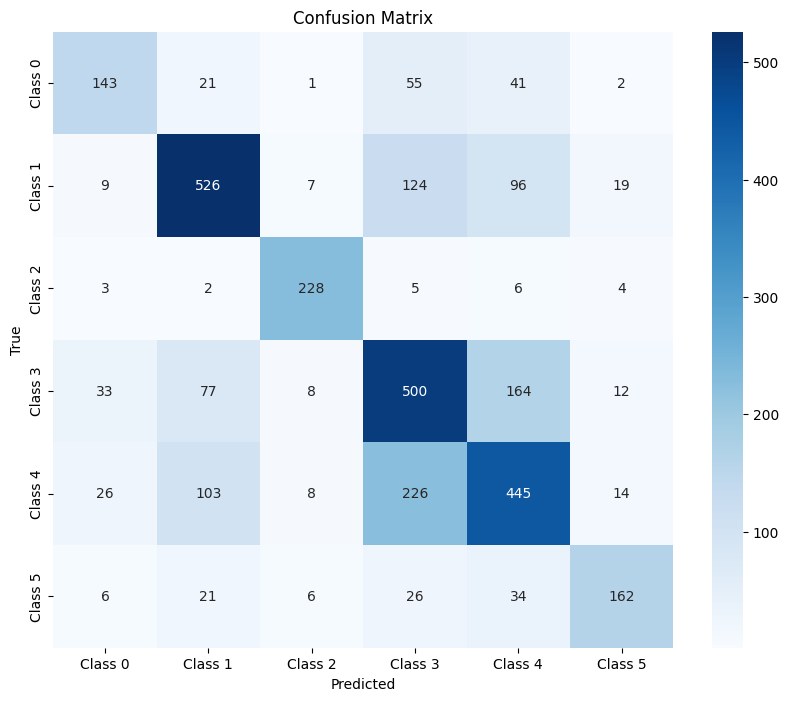

In [64]:
# Compute the confusion matrix
conf_matrix = confusion_matrix(y_val_true_classes, y_val_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[f'Class {i}' for i in range(6)], yticklabels=[f'Class {i}' for i in range(6)])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()



In [65]:
final_model.save('VGG_freeze.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
